In [1]:
import pandas as pd
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
%matplotlib inline  


## Hur många bilar kommer det finnas år 2030?

Från [SCB](https://www.scb.se/hitta-statistik/statistik-efter-amne/transporter-och-kommunikationer/vagtrafik/fordonsstatistik/pong/tabell-och-diagram/personbilar-i-trafik/) hämtar vi uppgifter om historiska antal personbilar.


In [2]:
url = "https://www.scb.se/contentassets/e4460d67aa3347679dc460e5ae93a6c6/tk1001ford5-2019.xls"
df_n_cars = pd.read_excel(url, skiprows=4).rename(columns={"Year": "year", "Passenger cars": "observed"})\
.set_index("year")

df_n_cars["observed"].plot()


Från Trafikanalys rapport [Vägfordonsflottans utveckling till år 2030](https://www.trafa.se/globalassets/pm/2020/pm-2020_7-vagfordonflottans-utveckling-till-ar-2030.pdf) hämtar vi en prognos om att Sverige kommer ha 5,5 miljoner personbilar år 2030 (sid 25).



In [3]:
latest_year = df_n_cars["observed"].index.max()
n_years = 2030 - latest_year
growth = 5.5e6 / df_n_cars.loc[latest_year]["observed"]
growth_rate = pow(growth, 1/n_years) 


md(f"Det motsvarar en tillväxttakt på **{(growth_rate - 1):.1%}**")


Det motsvarar en tillväxttakt på **1.1%**

In [4]:
import numpy as np
_prev_val = df_n_cars.loc[latest_year]["observed"]
for year in np.arange(int(latest_year)+1, 2031):
    _val = _prev_val * growth_rate
    df_n_cars.loc[year, "projected"] = _val
    _prev_val = _val

df_n_cars["observed"].plot()
df_n_cars["projected"].plot()

## Hur stort kommer det totala trafikarbetet vara?

[Trafikverket](http://trafikverket.diva-portal.org/smash/get/diva2:1484841/FULLTEXT01.pdf) räknar med att trafikarbetet kommer öka med **1,0 procent** per år (sid 10).



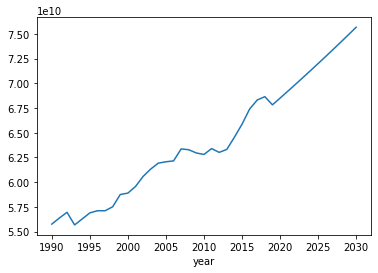

In [5]:
growth_rate = 1.01

# som miljoner fordons-km
s_traffic_work = pd.read_excel("../data/trafikarbete-pa-svenska-vagar-1990-2019okt.xlsx",
                              sheet_name="Trafikarbete", skiprows=3)\
.iloc[4:,:].rename(columns={"År": "year"}).set_index("year")["Personbil"] * 1e6
s_traffic_work.index = s_traffic_work.index.astype(int)

for year in range(s_traffic_work.index[-1] + 1, 2031):
    s_traffic_work[year] = s_traffic_work[year - 1] * growth_rate

s_traffic_work.plot()

## Vilka årsmodeller kommer rulla på vägarna år 2030?

Från BIL Sweden (Jonas Eliasson) har vi fått uppgifter om fördelningen av bilar per årsmodell år 2016, samt fördelningen deras andel av det totala trafikarbetet.

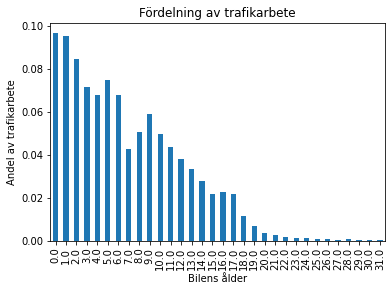

In [6]:

df_per_car_age = pd.read_excel("../data/Jonas Eliasson - Nyckeltal från BIL Swedens färdplan.xlsx")[["årsmodell", "antal bilar", "mil/bil (kursivt = imputerade data)"]]\
.rename(columns={"antal bilar": "n_cars", "mil/bil (kursivt = imputerade data)": "km_per_car"})
df_per_car_age["car_age"] = (2016 - df_per_car_age["årsmodell"])
df_per_car_age = df_per_car_age[df_per_car_age["car_age"].notna()]\
.set_index("car_age").drop("årsmodell", axis=1)

df_per_car_age["km_per_car"] = df_per_car_age["km_per_car"] * 10 # mil => km
df_per_car_age["milage"] = df_per_car_age["km_per_car"] * df_per_car_age["n_cars"]
df_per_car_age["share_of_count"] = df_per_car_age["n_cars"] / df_per_car_age["n_cars"].sum()
df_per_car_age["share_of_mileage"] = df_per_car_age["milage"] / df_per_car_age["milage"].sum()
ax = df_per_car_age["share_of_count"].sort_index().plot.bar(title="Bilparkens ålder (2016)")
ax.set_xlabel("Bilens ålder")
ax.set_ylabel("Andel av personbilar")
plt.show()

ax = df_per_car_age["share_of_mileage"].sort_index().plot.bar(title="Fördelning av trafikarbete")
ax.set_xlabel("Bilens ålder")
ax.set_ylabel("Andel av trafikarbete")
plt.show()

In [7]:
n_cars_2030 = df_n_cars.loc[2030]["projected"]


In [8]:
cars_by_year_model_2030 = df_per_car_age["share_of_count"]
cars_by_year_model_2030.index = [2030 - x for x in n_cars_per_car_age.index]

colors = ["steelblue" if x <= 2020 else "gray" for x in cars_by_year_model_2030.index]
old_share = cars_by_year_model_2030[cars_by_year_model_2030.index <= 2020].sum()

title = f"{old_share:.0%} av alla bilar år 2030 är årsmodell 2020 (eller tidigare)"
ax = cars_by_year_model_2030.plot.bar(color=colors, title=title)
ax.set_xlabel("Årsmodell")
plt.show()


NameError: name 'n_cars_per_car_age' is not defined

## Hur mycket kommer fordonen släppa ut i snitt, år för år?

Här återskapar vi Jonas Elissons beräkningar från [fordonsindustrins färdplan](https://fossilfrittsverige.se/wp-content/uploads/2020/09/Fardplan_Latta-fordon.pdf).

Vi utgår de genomsnittliga CO2-utsläppen för befintliga bilmodeller. 


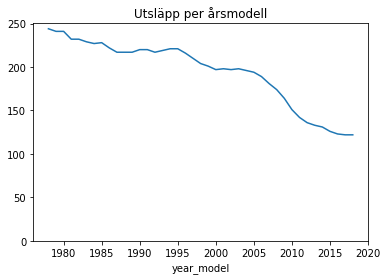

In [9]:
s_co2_by_year_model = pd.read_excel("../data/Jonas Eliasson - Nyckeltal från BIL Swedens färdplan.xlsx")\
.rename(columns={"Årsmodell": "year_model", "CO2 g/km bränslebilar": "co2_per_km"})\
.set_index("year_model")["co2_per_km"]
ax = s_co2_by_year_model.plot(title="Utsläpp per årsmodell")
ax.set_ylim(0)
plt.show()

För att räkna ut utsläppen ett visst år multiplicerar vi utsläppen per årsmodell med trafikarbetet. Vi antar att fördelningen av trafikarbetet mellan olika årsmodeller är konstant över tid. 

I följande bild ser vi att modellen ger i stort sett samma värden som de faktiska, observerade värdena vi kan hämt från [Naturvårdsverket](https://www.naturvardsverket.se/Sa-mar-miljon/Statistik-A-O/Vaxthusgaser-utslapp-fran-inrikes-transporter/).

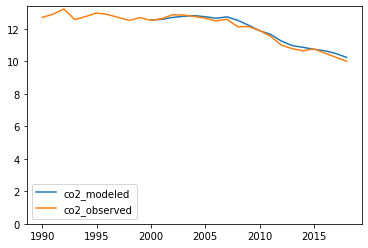

In [10]:
def compute_total_co2(year, s_co2_by_ym):
    s_traffic_work_by_year = df_per_car_age["share_of_mileage"] * s_traffic_work.loc[year]
    s_traffic_work_by_year.index = [int(year - x) for x in s_traffic_work_by_year.index]
    print(s_traffic_work_by_year, s_co2_by_ym)
    return (s_traffic_work_by_year * s_co2_by_ym).sum() / 1e12
    
years = range(2000,2019)
co2_modeled = pd.Series(years, index=years)\
                .apply(compute_total_co2, args=(s_co2_by_year_model,))\
                .rename("co2_modeled")
co2_observed = pd.read_csv("../data/naturvårdsverket - Utsläpp av växthusgaser från inrikes transporter.csv", 
                         encoding="iso-8859-1")\
               .set_index("Unnamed: 0")\
               .loc["Bilar"]\
                .rename("co2_observed") / 1000
co2_observed.index = co2_observed.index.astype(int)
ax  = pd.concat([co2_modeled, co2_observed], axis=1).plot()
ax.set_ylim(0)
plt.show()

## Hur behöver se ut för att nå 2030-målet?

Klimatmålet är ett minska utsläppen med 70 procent mellan 2010 och 2030. Följande bild visar att vi inte håller den banan, utan behöver minska utsläppen snabbare.

In [185]:
# För olika co2-projektioner
years = pd.Series(range(2010,2031))
df_co2_proj = pd.DataFrame(index=years)

co2_2010 = co2_observed.loc[2010]
co2_2018 = co2_observed.loc[2018]
co2_2030 = co2_2010 * 0.3

n_years_2010 = 2030 - 2010
n_years_2018 = 2030 - 2018
yearly_change_2010 = pow(0.3, 1 / n_years_2010)
yearly_change_2018 = pow(co2_2030 / co2_2018, 1 / n_years_2018)
md(f"""
För att nå 2030-målet behöver utsläppen minska med {abs(yearly_change_2018 - 1):.0%} per år från 2018.
""") 

df_co2_proj["jämn minskning från 2018"] = df_co2_proj.index.map(lambda x: pow(yearly_change_2018, n_years_2018 - (2030 - x)) * co2_2018)
df_co2_proj["jämn minskning från 2010"] = df_co2_proj.index.map(lambda x: pow(yearly_change_2010, n_years_2010 - (2030 - x)) * co2_2010)


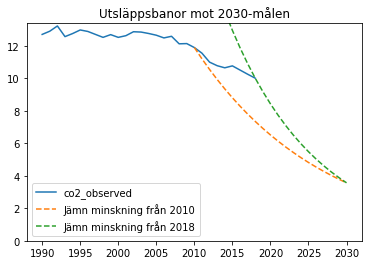

In [186]:
co2_2010 = co2_observed.loc[2010]
co2_2018 = co2_observed.loc[2018]
co2_2030 = co2_2010 * 0.3

pow(0.3, 1/20) - 1

ax = co2_observed.plot(title="Utsläppsbanor mot 2030-målen")
ax.set_ylim(0)
df_co2_proj["jämn minskning från 2010"].plot(linestyle='dashed', label="Jämn minskning från 2010")
df_co2_proj["jämn minskning från 2018"].plot(linestyle='dashed', label="Jämn minskning från 2018")

ax.legend()

## Hur mycket skulle utsläppen minska om vi bara sålde elbilar från och med nu?

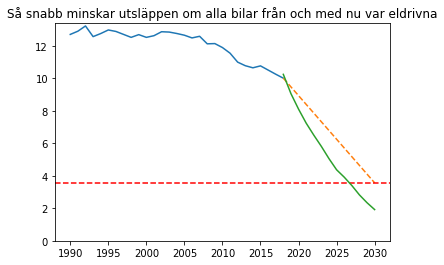

In [187]:
def draw_base_chart():
    ax = co2_observed.plot()
    ax.set_ylim(0)
    ax.plot([2018, 2030],[co2_2018, co2_2030],  linestyle='dashed', label="Jämn minskning från 2018")
    ax.axhline(co2_2030, c="red", linestyle='dashed')
    return ax
    
_ = s_co2_by_year_model.copy()

s_electronic_only = _.append(pd.Series(index=range(2019,2031), dtype=float).fillna(0))

years = range(2018,2031)
co2_modeled = pd.Series(years, index=years)\
                .apply(compute_total_co2, args=(s_electronic_only,))\
                .rename("co2_modeled")

ax = draw_base_chart()
co2_modeled.plot(title="Så snabb minskar utsläppen om alla bilar från och med nu var eldrivna")

df_co2_proj["bara elbilar från 2018"] = co2_modeled


## Hur mycket minskar utsläppen i färdplanens scenario?

I [Fossilfritt Sveriges färdplan](https://fossilfrittsverige.se/wp-content/uploads/2020/09/Fardplan_Latta-fordon.pdf) antas nya fordon effektiveras med 1,5 procent per år (figur 9). 

Från [Trafikverkets rapport](https://trafikverket.ineko.se/Files/en-US/74700/Ineko.Product.RelatedFiles/2020_080_scenarier_for_att_na_klimatmalet_for_inrikes_transporter_ett_regeringsuppdrag.pdf) om olika framtidsscenarier för att nå 2030- och 2040-mål (sid 26):

> I de scenarier som når målen antas Sverige kunna nå längre än EU-kraven genom nationella styrmedel. Genom förstärkning av bonus-malus inklusive påverkan på förmånsvärdet samt utbyggnad av laddinfrastruktur för elbilar och laddhybrider,bedöms det vara möjligt att nå en reduktion av koldioxidutsläppen med 50 procent för lätta fordon jämfört med 2021.Detta sker i scenarierna genom en ökning av andelen laddbara fordon,medaneffektiviseringen av icke laddbara fordon inte påverkas i nämnvärd grad. Det innebär att även i detta fallnås 85 g/km för nya icke laddbara personbilar till 2030,samtidigt som el-andelenav körsträckan för nya fordon uppgår till 44 procent. Detta skulle kunna motsvara **50 till 65 procent laddbara fordon**. 

Här antar vi att de rena elbilar trappas upp till 50 procent år 2030 (från 4,8 procent i början av 2019).

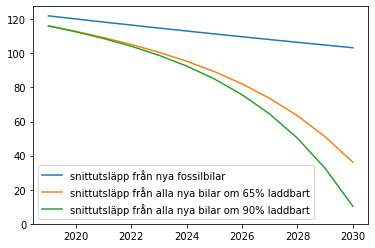

_i  fossil_cars  _el_car_share  _el_car_share_high    all_cars  \
2019   0   122.000000       0.048000            0.048000  116.144000   
2020   1   120.170000       0.060830            0.062657  112.860013   
2021   2   118.367450       0.077090            0.081789  109.242466   
2022   3   116.591938       0.097697            0.106764  105.201312   
2023   4   114.843059       0.123811            0.139364  100.624253   
2024   5   113.120413       0.156905            0.181919   95.371219   
2025   6   111.423607       0.198846            0.237468   89.267464   
2026   7   109.752253       0.251997            0.309979   82.094960   
2027   8   108.105969       0.319356            0.404632   73.581645   
2028   9   106.484380       0.404720            0.528187   63.388009   
2029  10   104.887114       0.512902            0.689470   51.090343   
2030  11   103.313807       0.650000            0.900000   36.159833   

      all_cars_high  
2019     116.144000  
2020     112.640525  
2021     108.686270  
2022     104.144158  
2023      98.838064  
2024      92.541655  
2025      84.964037  
2026      75.731306  
2027      64.362823  
2028      50.240711  
2029      32.570638  
2030      10.331381

In [195]:

years = range(2019,2031)

df_new_car_emissions = pd.DataFrame(index=years)
df_new_car_emissions["_i"] = range(0, len(years))
#df_new_car_emissions["_i"] = years[-1] - df_new_car_emissions.index
# hur mycket väntas nya fossilbilar släppa ut?
df_new_car_emissions["fossil_cars"] = df_new_car_emissions["_i"].apply(lambda x: pow(0.985, x) * _.loc[2018]) 

# hur stor andel 
el_car_share_2019 = 0.048
el_car_share_2030 = 0.65
el_car_share_2030_high = 0.9
n_years = 2030 - 2019
el_car_growth = pow(el_car_share_2030 / el_car_share_2019, 1 / (n_years))
el_car_growth_high = pow(el_car_share_2030_high / el_car_share_2019, 1 / (n_years))

df_new_car_emissions["_el_car_share"] = df_new_car_emissions["_i"].apply(lambda x: pow(el_car_growth, x) * el_car_share_2019)
df_new_car_emissions["_el_car_share_high"] = df_new_car_emissions["_i"].apply(lambda x: pow(el_car_growth_high, x) * el_car_share_2019)
df_new_car_emissions["all_cars"] = df_new_car_emissions["fossil_cars"] * (1 - df_new_car_emissions["_el_car_share"])
df_new_car_emissions["all_cars_high"] = df_new_car_emissions["fossil_cars"] * (1 - df_new_car_emissions["_el_car_share_high"])

ax = df_new_car_emissions[["fossil_cars", "all_cars", "all_cars_high"]]\
.rename(columns={"fossil_cars": "snittutsläpp från nya fossilbilar", 
                 "all_cars": f"snittutsläpp från alla nya bilar om {el_car_share_2030:.0%} laddbart",
                 "all_cars_high": f"snittutsläpp från alla nya bilar om {el_car_share_2030_high:.0%} laddbart",
                })\
.plot()
ax.set_ylim(0)
plt.show()
df_new_car_emissions

In [196]:


_ = s_co2_by_year_model.copy()
df_co2_proj[f"elbilsökning till {el_car_share_2030:.0%} år 2030"] = pd.Series(years, index=years).apply(compute_total_co2, args=(_.append(df_new_car_emissions["all_cars"]),))
df_co2_proj[f"elbilsökning till {el_car_share_2030_high:.0%} år 2030"] = pd.Series(years, index=years).apply(compute_total_co2, args=(_.append(df_new_car_emissions["all_cars_high"]),))
df_co2_proj

jämn minskning från 2018  jämn minskning från 2010  \
2010                 19.903177                 11.892000   
2011                 18.263966                 11.197239   
2012                 16.759759                 10.543068   
2013                 15.379438                  9.927116   
2014                 14.112799                  9.347149   
2015                 12.950479                  8.801065   
2016                 11.883887                  8.286884   
2017                 10.905139                  7.802744   
2018                 10.007000                  7.346888   
2019                  9.182831                  6.917664   
2020                  8.426540                  6.513517   
2021                  7.732536                  6.132981   
2022                  7.095690                  5.774676   
2023                  6.511295                  5.437305   
2024                  5.975029                  5.119644   
2025                  5.482930                  4.820542   
2026                  5.031360                  4.538913   
2027                  4.616981                  4.273739   
2028                  4.236730                  4.024056   
2029                  3.887796                  3.788961   
2030                  3.567600                  3.567600   

      bara elbilar från 2018  elbilsökning till 65% år 2030  \
2010                     NaN                            NaN   
2011                     NaN                            NaN   
2012                     NaN                            NaN   
2013                     NaN                            NaN   
2014                     NaN                            NaN   
2015                     NaN                            NaN   
2016                     NaN                            NaN   
2017                     NaN                            NaN   
2018               10.242857                            NaN   
2019                9.057913                       9.817966   
2020                8.104382                       9.608941   
2021                7.243013                       9.397671   
2022                6.505184                       9.192713   
2023                5.807856                       8.982294   
2024                5.056202                       8.754982   
2025                4.370876                       8.512301   
2026                3.917300                       8.255139   
2027                3.404078                       7.967532   
2028                2.825183                       7.636932   
2029                2.342994                       7.253946   
2030                1.920783                       6.798316   

      elbilsökning till 90% år 2030  
2010                            NaN  
2011                            NaN  
2012                            NaN  
2013                            NaN  
2014                            NaN  
2015                            NaN  
2016                            NaN  
2017                            NaN  
2018                            NaN  
2019                       9.817966  
2020                       9.607490  
2021                       9.392510  
2022                       9.180580  
2023                       8.958580  
2024                       8.713089  
2025                       8.442727  
2026                       8.144577  
2027                       7.797783  
2028                       7.382675  
2029                       6.880153  
2030                       6.257098

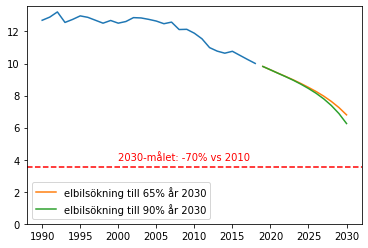

In [202]:
ax = co2_observed.rename("historiska utsläpp").plot()
df_co2_proj[["elbilsökning till 65% år 2030", "elbilsökning till 90% år 2030"]].plot(ax=ax)
ax.set_ylim(0)
ax.axhline(co2_2030, c="red", linestyle='dashed')
plt.text(2000, co2_2030 + 0.4, "2030-målet: -70% vs 2010", c="red")
plt.show()

## Är det här i linje med CO2-budget?

In [178]:
import requests
r = requests.get("https://storage.googleapis.com/klimatsekretariatet-static/climate-visualizer/sweden/sweden.json")
json_data = r.json()

In [179]:
co2_budget = json_data["region"]["budget"]["tCO2"]

total_emissions = json_data["region"]["emissions"]["_sum"]["_sum"][-1]
car_emissions = json_data["region"]["emissions"]["Inrikes transporter"]["Personbilar"][-1]
car_emission_share = car_emissions / total_emissions
co2_budget_cars = car_emission_share * co2_budget  / 1e6

md(f"""
Personbilarna utgör {car_emission_share:.0%} av de totala utsläppen i Sverige. 

Om vi ger personbilarna motsvarande del av den återstående CO2-budgeten innebär det **{round(co2_budget_cars)} miljoner ton** koldioxid.
""")


Personbilarna utgör 15% av de totala utsläppen i Sverige. 

Om vi ger personbilarna motsvarande del av den återstående CO2-budgeten innebär det **48 miljoner ton** koldioxid.


Text(2021, 46.73801742155115, 'Budgettak')

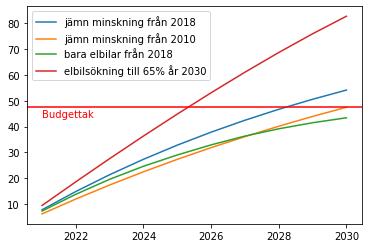

In [190]:
title = "Om "
ax = df_co2_proj[df_co2_proj.index > 2020].cumsum().plot()
plt.axhline(co2_budget_cars, color="red")
plt.text(2021, co2_budget_cars - 1, "Budgettak", color="red", va="top")

## Hur många fordon av olika bränsletyp kommer det finnas år 2030?

I IVL:s [Transportstudien 2019](https://www.ivl.se/download/18.34244ba71728fcb3f3fb02/1591706113596/C450.pdf) görs en prognos över vägarbete per bränsletyp.

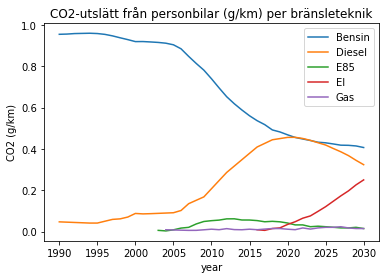

In [161]:
# I brist på bakomliggande data har vi "ocr":at diagrammet för hand 
df_chart_data_raw = pd.read_csv("../data/IVL - prognos över trafikarbete per bränsletyp - ocr.csv")
parsed_data = []
for fuel, _df in df_chart_data_raw.groupby("fuel"):
    y0 = _df["year"].min()
    y1 = _df["year"].max()
    years = np.arange(int(np.round(y0)),int(np.round(y1)) + 1)
    for y in years:
        try:
            x0 = _df[_df["year"] < y].iloc[-1]
        except IndexError:
            x0 = _df.iloc[0]
        
        x1 = _df.iloc[_df.index.get_loc(x0.name) + 1]

        val = (1 - (x1["year"] - y) / (x1["year"] - x0["year"])) * (x1["share"] - x0["share"]) + x0["share"]
        
        parsed_data.append({
            "year": y,
            "fuel": fuel,
            "share": val
        })
                              
    
df_co2_per_fuel = pd.DataFrame(parsed_data)

title ="CO2-utslätt från personbilar (g/km) per bränsleteknik"

ax = plt.gca()
df_co2_per_fuel.set_index("year").groupby("fuel")["share"].plot(title=title)
ax.set_ylabel("CO2 (g/km)")
ax.legend()

I det här scenariot når vi *nästan* 70 procents reduktion av utsläppen från transportsektorn. 

Den bygger på följande antagangen om nybilsförsäljning.

fossil  laddhybrid     el
2018-01-01    0.92       0.059  0.019
2019-01-01    0.87       0.093  0.037
2020-01-01    0.78       0.150  0.070
2025-01-01    0.58       0.280  0.140
2030-01-01    0.40       0.250  0.350

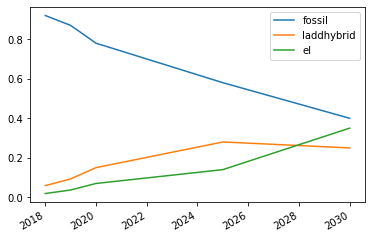

In [204]:
# Manuellt utplockade värden från Tabell 2
# https://www.ivl.se/download/18.34244ba71728fcb3f3fb02/1591706113596/C450.pdf
from datetime import datetime

df_new_reg_proj = pd.concat([
    pd.Series([92,87,78,58,40], name="fossil"),
    pd.Series([5.9,9.3,15,28,25], name="laddhybrid"),
    pd.Series([1.9,3.7,7,14,35], name="el"),
    
], axis=1) / 100
df_new_reg_proj.index = pd.DatetimeIndex([datetime(x,1,1) for x in [2018,2019,2020,2025,2030]])

df_new_reg_proj.plot()
df_new_reg_proj


Hur matchar detta den verkliga nyregistrering? Här hämtar vi data från [SCB](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__TK__TK1001__TK1001A/PersBilarDrivMedel/).


In [205]:
df_new_reg = pd.read_csv("../data/TK1001AA_20201128-221736.csv", encoding="iso-8859-1", skiprows=2)\
.drop("region",axis=1)\
.rename(columns={"drivmedel": "fuel"}).set_index("fuel").T

df_new_reg.index = [datetime.strptime(x, "%YM%m") for x in df_new_reg.index]
df_new_reg["fossil"] = (df_new_reg["bensin"] + 
                        df_new_reg["diesel"] +
                        df_new_reg["etanol/etanol flexifuel"] + 
                        df_new_reg["gas/gas flexifuel"] + 
                        df_new_reg["elhybrid"])

df_new_reg = df_new_reg[["fossil", "laddhybrid","el"]].divide(df_new_reg[["fossil", "laddhybrid","el"]].sum(axis=1), axis=0)

df_new_reg

fuel          fossil  laddhybrid        el
2018-01-01  0.925797    0.066182  0.008021
2018-02-01  0.932691    0.055659  0.011650
2018-03-01  0.929676    0.050589  0.019735
2018-04-01  0.939154    0.050256  0.010590
2018-05-01  0.949193    0.043379  0.007428
2018-06-01  0.959763    0.035248  0.004989
2018-07-01  0.823018    0.138353  0.038629
2018-08-01  0.900908    0.077162  0.021930
2018-09-01  0.879708    0.086749  0.033543
2018-10-01  0.888903    0.077685  0.033412
2018-11-01  0.886060    0.067992  0.045948
2018-12-01  0.885049    0.068219  0.046732
2019-01-01  0.873082    0.074683  0.052235
2019-02-01  0.882214    0.079869  0.037917
2019-03-01  0.858453    0.073750  0.067797
2019-04-01  0.901803    0.054409  0.043788
2019-05-01  0.912473    0.049779  0.037748
2019-06-01  0.896116    0.052787  0.051096
2019-07-01  0.904205    0.052387  0.043409
2019-08-01  0.913450    0.054705  0.031845
2019-09-01  0.868783    0.067592  0.063625
2019-10-01  0.883777    0.088414  0.027810
2019-11-01  0.861265    0.104614  0.034122
2019-12-01  0.899624    0.066649  0.033728
2020-01-01  0.697453    0.231210  0.071336
2020-02-01  0.757326    0.179081  0.063592
2020-03-01  0.727725    0.166597  0.105678
2020-04-01  0.784043    0.163052  0.052905
2020-05-01  0.796911    0.153323  0.049766
2020-06-01  0.754280    0.180241  0.065479
2020-07-01  0.717617    0.227469  0.054914
2020-08-01  0.720437    0.199699  0.079864
2020-09-01  0.667271    0.209252  0.123477
2020-10-01  0.648906    0.270329  0.080765

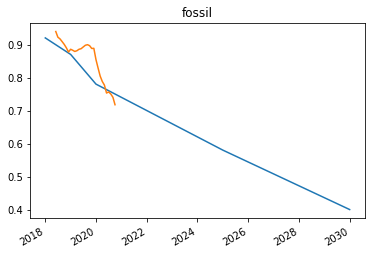

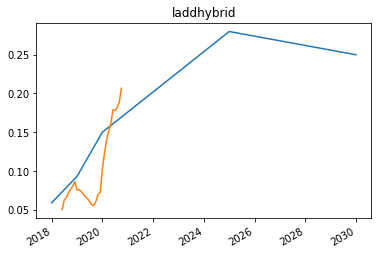

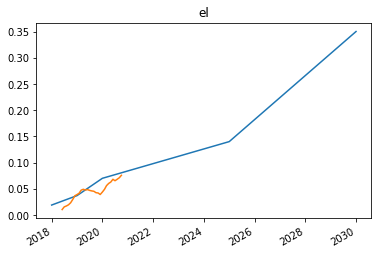

In [208]:
for fuel in df_new_reg_proj.columns:
    df_new_reg_proj[fuel].plot(title=fuel)
    df_new_reg[fuel].rolling(6).mean().plot()
    plt.show()

## Hur mycket koldioxid kommer personbilarna släppa ut?

I IVL:s [Omvärldsanalys och långtidsbedömning av den svenska vägfordonsflottans utveckling](https://www.ivl.se/download/18.7342a03f17582337c283160/1605084260539/C476.pdf) (sid 51) görs en prognos på hur mycket koldioxid bilar med olika bränsletyper kommer att släppa ut till och med 2030. 

https://apps.automeris.io/wpd/

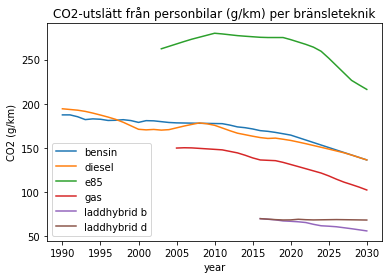

In [160]:
# I brist på bakomliggande data har vi "ocr":at diagrammet för hand 
df_chart_data_raw = pd.read_csv("../data/IVL - co2 per bränsleteknik personbilar - ocr.csv")
parsed_data = []
for fuel, _df in df_chart_data_raw.groupby("fuel"):
    y0 = _df["year"].min()
    y1 = _df["year"].max()
    years = np.arange(int(np.round(y0)),int(np.round(y1)) + 1)
    for y in years:
        try:
            x0 = _df[_df["year"] < y].iloc[-1]
        except IndexError:
            x0 = _df.iloc[0]
        
        x1 = _df.iloc[_df.index.get_loc(x0.name) + 1]

        val = (1 - (x1["year"] - y) / (x1["year"] - x0["year"])) * (x1["co2_per_km"] - x0["co2_per_km"]) + x0["co2_per_km"]
        
        parsed_data.append({
            "year": y,
            "fuel": fuel,
            "co2_per_km": val
        })
                              
    
df_co2_per_fuel = pd.DataFrame(parsed_data)

title ="CO2-utslätt från personbilar (g/km) per bränsleteknik"

ax = plt.gca()
df_co2_per_fuel.set_index("year").groupby("fuel")["co2_per_km"].plot(title=title)
ax.set_ylabel("CO2 (g/km)")
ax.legend()

In [144]:
y = 2020.0
try:
    x0 = _df[_df["year"] < y].iloc[-1]
except IndexError:
    x0 = _df.iloc[0]

x1 = _df.iloc[_df.index.get_loc(x0.name) + 1]

val = (x1["year"] - y) / (x1["year"] - x0["year"]) * (x1["co2_per_km"] - x0["co2_per_km"]) + x0["co2_per_km"]


_df


year  co2_per_km          fuel
59  2016.000000   69.525241  laddhybrid d
60  2018.670799   68.027157  laddhybrid d
61  2019.870803   68.019744  laddhybrid d
62  2021.248000   68.999703  laddhybrid d
63  2022.359701   68.004368  laddhybrid d
64  2026.048311   68.475814  laddhybrid d
65  2030.000000   67.957964  laddhybrid d

In [120]:
df_raw = pd.read_excel("../data/Jonas Eliasson - Nyckeltal från BIL Swedens färdplan.xlsx")

df_per_year_model = df_raw[["Årsmodell", "CO2 g/km bränslebilar"]]\
.rename(columns={"Årsmodell": "year_model", "CO2 g/km bränslebilar": "co2_per_km"})\
.set_index("year_model")

df_per_year_model

co2_per_km
year_model            
1978               244
1979               241
1980               241
1981               232
1982               232
1983               229
1984               227
1985               228
1986               222
1987               217
1988               217
1989               217
1990               220
1991               220
1992               217
1993               219
1994               221
1995               221
1996               216
1997               210
1998               204
1999               201
2000               197
2001               198
2002               197
2003               198
2004               196
2005               194
2006               189
2007               181
2008               174
2009               164
2010               151
2011               142
2012               136
2013               133
2014               131
2015               126
2016               123
2017               122
2018               122

In [ ]:
https://www.ivl.se/download/18.7342a03f17582337c283160/1605084260539/C476.pdf